In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aisdata/real_test.csv
/kaggle/input/aisdata/valid.csv
/kaggle/input/aisdata/train.csv
/kaggle/input/aisdata/test.csv


In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

# 配置
feature_cols = ["LAT", "LON", "SOG", "COG"]
output_cols = ["LAT", "LON"]
input_len = 6
output_len = 1
slide_step = 1

# 滑动窗口构造函数
def create_sliding_windows(data, input_len=5, output_len=1, step=1):
    X, y = [], []
    for i in range(0, len(data) - input_len - output_len + 1, step):
        X.append(data[i:i+input_len, :])
        y.append(data[i+input_len:i+input_len+output_len, :2])  # 只取LAT, LON作为输出
    return np.array(X), np.array(y)

# 数据构造函数
def generate_dataset_from_file(file_path):
    df = pd.read_csv(file_path, parse_dates=["BaseDateTime"])
    X_all, y_all = [], []

    for mmsi, group in df.groupby("MMSI"):
        ship_data = group.sort_values("BaseDateTime")
        if len(ship_data) < input_len + output_len:
            continue
        values = ship_data[feature_cols].values
        X, y = create_sliding_windows(values, input_len, output_len, slide_step)
        if len(X) > 0:
            X_all.append(X)
            y_all.append(y)

    return np.concatenate(X_all, axis=0), np.concatenate(y_all, axis=0)

# 加载数据集
X_train, y_train = generate_dataset_from_file("/kaggle/input/aisdata/train.csv")
X_val, y_val = generate_dataset_from_file("/kaggle/input/aisdata/valid.csv")
X_test, y_test = generate_dataset_from_file("/kaggle/input/aisdata/test.csv")

print("训练集样本数：", X_train.shape)
print("验证集样本数：", X_val.shape)
print("测试集样本数：", X_test.shape)
print("样本示例：")
print("输入形状：", X_train[0].shape)
print("输出形状：", y_train[0].shape)

训练集样本数： (754082, 6, 4)
验证集样本数： (106432, 6, 4)
测试集样本数： (121083, 6, 4)
样本示例：
输入形状： (6, 4)
输出形状： (1, 2)


In [2]:
class AISTrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AISTrajectoryDataset(X_train, y_train)
val_dataset = AISTrajectoryDataset(X_val, y_val)
test_dataset = AISTrajectoryDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [59]:
def get_model(name: str):
    name = name.lower()
    if name == "gru":
        return GRU()
    elif name == "bilstm":
        return BiLSTM()
    elif name == "transformer":
        return Transformer()
    elif name == "bilstmtransformer":
        return BiLSTMTransformer()
    elif name == "grubilstmtransformer":
        return GRUBiLSTMTransformer()

    elif name == "lstm":
        return LSTM()
    elif name == "cnnlstm":
        return CNNLSTM()
    elif name == "lstmattn":
        return LSTMAttention()
    elif name == "cnnlstmattn":
        return CNNLSTMAttention()
    else:
        raise ValueError(f"Unsupported model type: {name}.")


In [6]:
import csv
import os

def train_and_evaluate_model(model_name, train_loader, val_loader,
                           model_dir, log_dir, lr=1e-3, weight_decay=1e-4,
                           epochs=50, patience=5, device='cpu'):
    model = get_model(model_name).to(device)
    print(model)
    model_path = os.path.join(model_dir, f"s_{model_name}_best.pt")
    log_path = os.path.join(log_dir, f"s_{model_name}_log.csv")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_loss = float('inf')
    wait = 0

    # 写入 CSV 日志头（固定8位小数）
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'TrainLoss', 'ValLoss'])

    for epoch in range(epochs):
        # === 训练 ===
        model.train()
        train_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device).squeeze(1)
            optimizer.zero_grad()
            output = model(X)
            loss = F.mse_loss(output, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # === 验证 ===
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device).squeeze(1)
                output = model(X)
                val_losses.append(F.mse_loss(output, y).item())
        avg_val_loss = np.mean(val_losses)

        # === 固定写入8位小数 ===
        with open(log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                f"{avg_train_loss:.7f}",  # 固定8位小数
                f"{avg_val_loss:.7f}"
            ])

        # 控制台输出也保持8位（可选）
        print(f"[{model_name.upper()} Epoch {epoch+1:02d}] "
              f"Train Loss: {avg_train_loss:.7f}, "
              f"Val Loss: {avg_val_loss:.7f}")

        # Early stopping 逻辑
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch
import os

def evaluate_model(model_name, test_loader, model_dir, device='cpu'):
    # === 经纬度范围 ===
    lat_min, lat_max = 55.5, 58.0
    lon_min, lon_max = 10.3, 13.0

    # === 加载模型 ===
    model_path = os.path.join(model_dir, f"s_{model_name}_best.pt")
    model = get_model(model_name).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True ))
    model.eval()

    preds, trues = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).squeeze(1)
            output = model(X)
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    # === 手动反归一化 ===
    def denorm_lat(x):
        return x * (lat_max - lat_min) + lat_min

    def denorm_lon(x):
        return x * (lon_max - lon_min) + lon_min

    preds_denorm = np.zeros_like(preds)
    trues_denorm = np.zeros_like(trues)

    preds_denorm[:, 0] = denorm_lat(preds[:, 0])
    preds_denorm[:, 1] = denorm_lon(preds[:, 1])
    trues_denorm[:, 0] = denorm_lat(trues[:, 0])
    trues_denorm[:, 1] = denorm_lon(trues[:, 1])

    # === 计算误差 ===
    lat_mse = mean_squared_error(trues_denorm[:, 0], preds_denorm[:, 0])
    lat_rmse = np.sqrt(lat_mse)
    lat_mae = mean_absolute_error(trues_denorm[:, 0], preds_denorm[:, 0])

    lon_mse = mean_squared_error(trues_denorm[:, 1], preds_denorm[:, 1])
    lon_rmse = np.sqrt(lon_mse)
    lon_mae = mean_absolute_error(trues_denorm[:, 1], preds_denorm[:, 1])

    print(f"{model_name.upper()} Test - Latitude (LAT) - MSE: {lat_mse:.6f}, RMSE: {lat_rmse:.4f}, MAE: {lat_mae:.4f}")
    print(f"{model_name.upper()} Test - Longitude (LON) - MSE: {lon_mse:.6f}, RMSE: {lon_rmse:.4f}, MAE: {lon_mae:.4f}")

    total_mse = mean_squared_error(trues_denorm, preds_denorm)
    total_rmse = np.sqrt(total_mse)
    total_mae = mean_absolute_error(trues_denorm, preds_denorm)

    print(f"{model_name.upper()} Total - MSE: {total_mse:.6f}, RMSE: {total_rmse:.6f}, MAE: {total_mae:.6f}")

    errors = {
        "LAT": {"MSE": lat_mse, "RMSE": lat_rmse, "MAE": lat_mae},
        "LON": {"MSE": lon_mse, "RMSE": lon_rmse, "MAE": lon_mae}
    }

    return errors, preds_denorm, trues_denorm



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt


def plot_train_log(log_path, model_name=None):
    """可视化训练日志（适配高精度损失值）

    参数：
        log_path: 日志文件路径（包含8位小数损失值）
        model_name: 可选模型名称（显示在标题中）
    """
    # 1. 读取数据时确保高精度转换
    df = pd.read_csv(log_path, float_precision='high')  # 确保不丢失精度

    # 2. 创建画布
    plt.figure(figsize=(10, 6), dpi=100)

    # 3. 绘制曲线（对数坐标轴更适合小数值）
    plt.plot(df['Epoch'], df['TrainLoss'], 'b-', linewidth=2, label='Train Loss')
    plt.plot(df['Epoch'], df['ValLoss'], 'r--', linewidth=2, label='Val Loss')

    # 4. 添加标注
    title = f"Training Log - {model_name.upper()}" if model_name else "Training Log"
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)


    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = "/kaggle/working/"
log_dir = "/kaggle/working/"
print(device)

cuda


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # 输出2个值

    def forward(self, x):
        _, (h, _) = self.lstm(x)  # h shape: (1, batch, hidden_dim)
        return self.fc(h.squeeze(0))

In [12]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim=4, conv_dim=32, lstm_dim=128, dropout=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, conv_dim, kernel_size=3, padding=1),
            nn.ReLU()
            # 不使用 MaxPool1d
        )
        self.lstm = nn.LSTM(conv_dim, lstm_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_dim, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)           # (batch, channels, seq_len)
        x = self.conv(x)                 # (batch, conv_dim, seq_len)
        x = x.permute(0, 2, 1)           # (batch, seq_len, conv_dim)

        lstm_out, _ = self.lstm(x)       # (batch, seq_len, lstm_dim)
        h = lstm_out[:, -1, :]           # 取最后时刻输出

        h = self.dropout(h)
        return self.fc(h)


In [13]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1, bias=False)
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)                    # (B, T, H)

        weights = torch.softmax(self.attn(lstm_out), dim=1)  # (B, T, 1)
        context = torch.sum(weights * lstm_out, dim=1)       # (B, H)

        last_step = lstm_out[:, -1]                   # (B, H)
        fused = context + last_step                   # 残差连接

        return self.fc(fused)                         # (B, 2)


In [14]:
import torch
import torch.nn as nn

class CNNLSTMAttention(nn.Module):
    def __init__(self, input_dim=4, conv_dim=32, lstm_dim=128):
        super().__init__()
        
        # 1. CNN部分（严格按您原结构）
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, conv_dim, kernel_size=3, padding=1),
            nn.ReLU()  # 无Pooling，无BatchNorm
        )
        
        # 2. LSTM部分（单层单向）
        self.lstm = nn.LSTM(
            input_size=conv_dim,
            hidden_size=lstm_dim,
            batch_first=True
        )
        
        # 3. Attention核心计算层
        self.attn_fc = nn.Linear(lstm_dim, 1)  # 仅1个线性层计算注意力分数
        
        # 4. 输出层（保持原输出维度）
        self.fc = nn.Linear(lstm_dim, 2)

    def forward(self, x):
        # 输入形状: (batch, seq_len, input_dim)
        
        # 1. CNN处理（严格按您原实现）
        x = x.permute(0, 2, 1)  # (batch, input_dim, seq_len)
        x = self.conv(x)         # (batch, conv_dim, seq_len)
        x = x.permute(0, 2, 1)   # (batch, seq_len, conv_dim)
        
        # 2. LSTM处理
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_dim)
        
        # 3. Attention计算（最简实现）
        attn_scores = self.attn_fc(lstm_out)  # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # 归一化权重
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, lstm_dim)
        
        # 4. 输出
        return self.fc(context)

LSTM(
  (lstm): LSTM(4, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
[LSTM Epoch 01] Train Loss: 0.0183124, Val Loss: 0.0019764
[LSTM Epoch 02] Train Loss: 0.0036183, Val Loss: 0.0013481
[LSTM Epoch 03] Train Loss: 0.0025855, Val Loss: 0.0009388
[LSTM Epoch 04] Train Loss: 0.0020473, Val Loss: 0.0007547
[LSTM Epoch 05] Train Loss: 0.0018006, Val Loss: 0.0006711
[LSTM Epoch 06] Train Loss: 0.0016914, Val Loss: 0.0006390
[LSTM Epoch 07] Train Loss: 0.0016432, Val Loss: 0.0006131
[LSTM Epoch 08] Train Loss: 0.0016259, Val Loss: 0.0006061
[LSTM Epoch 09] Train Loss: 0.0016168, Val Loss: 0.0006119
[LSTM Epoch 10] Train Loss: 0.0016133, Val Loss: 0.0005972
[LSTM Epoch 11] Train Loss: 0.0016109, Val Loss: 0.0005963
[LSTM Epoch 12] Train Loss: 0.0016092, Val Loss: 0.0005936
[LSTM Epoch 13] Train Loss: 0.0016075, Val Loss: 0.0005912
[LSTM Epoch 14] Train Loss: 0.0016058, Val Loss: 0.0006027
[LSTM Epoch 15] Train Loss: 0.0016045, Val Loss: 0.0005964
[LSTM E

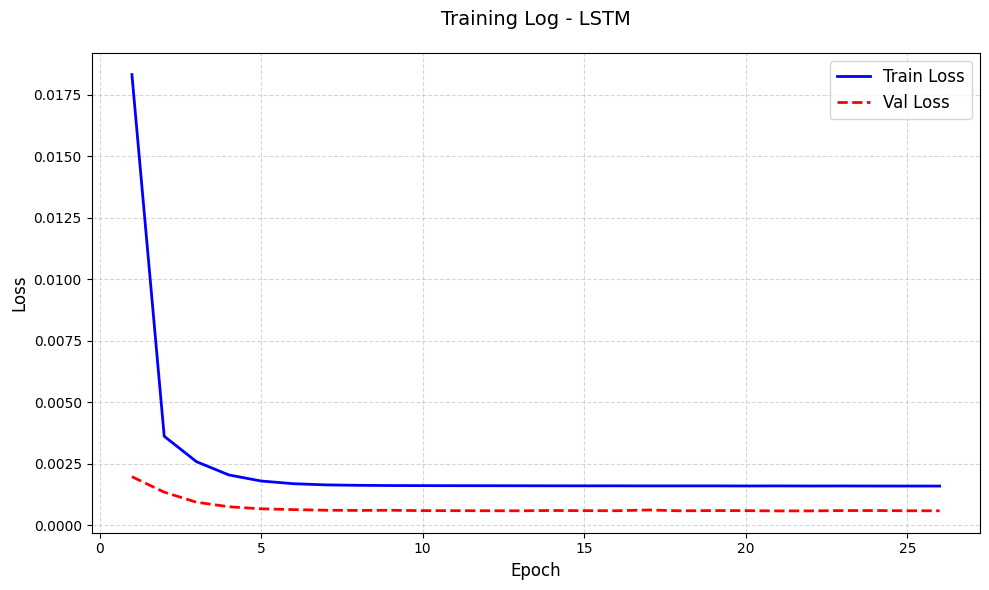

In [15]:
model_name = 'lstm'  # 修改模型名即可
train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=1e-4, weight_decay=1e-4, epochs=50, patience=5, device=device
)
# 可视化训练日志
plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [16]:
model_name = 'lstm'  # 修改模型名即可
errors_5, preds_5, trues_5 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

LSTM Test - Latitude (LAT) - MSE: 0.001111, RMSE: 0.0333, MAE: 0.0253
LSTM Test - Longitude (LON) - MSE: 0.002314, RMSE: 0.0481, MAE: 0.0253
LSTM Total - MSE: 0.001712, RMSE: 0.041378, MAE: 0.025321


CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (lstm): LSTM(32, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
[CNNLSTM Epoch 01] Train Loss: 0.0075792, Val Loss: 0.0006896
[CNNLSTM Epoch 02] Train Loss: 0.0021809, Val Loss: 0.0005628
[CNNLSTM Epoch 03] Train Loss: 0.0019898, Val Loss: 0.0005337
[CNNLSTM Epoch 04] Train Loss: 0.0018891, Val Loss: 0.0005299
[CNNLSTM Epoch 05] Train Loss: 0.0018132, Val Loss: 0.0005262
[CNNLSTM Epoch 06] Train Loss: 0.0017518, Val Loss: 0.0005098
[CNNLSTM Epoch 07] Train Loss: 0.0017060, Val Loss: 0.0005126
[CNNLSTM Epoch 08] Train Loss: 0.0016735, Val Loss: 0.0005558
[CNNLSTM Epoch 09] Train Loss: 0.0016489, Val Loss: 0.0005102
[CNNLSTM Epoch 10] Train Loss: 0.0016310, Val Loss: 0.0005258
[CNNLSTM Epoch 11] Train Loss: 0.0016205, Val Loss: 0.0004996
[CNNLSTM Epoch 12] Train Loss: 0.0016115, Val Loss: 0

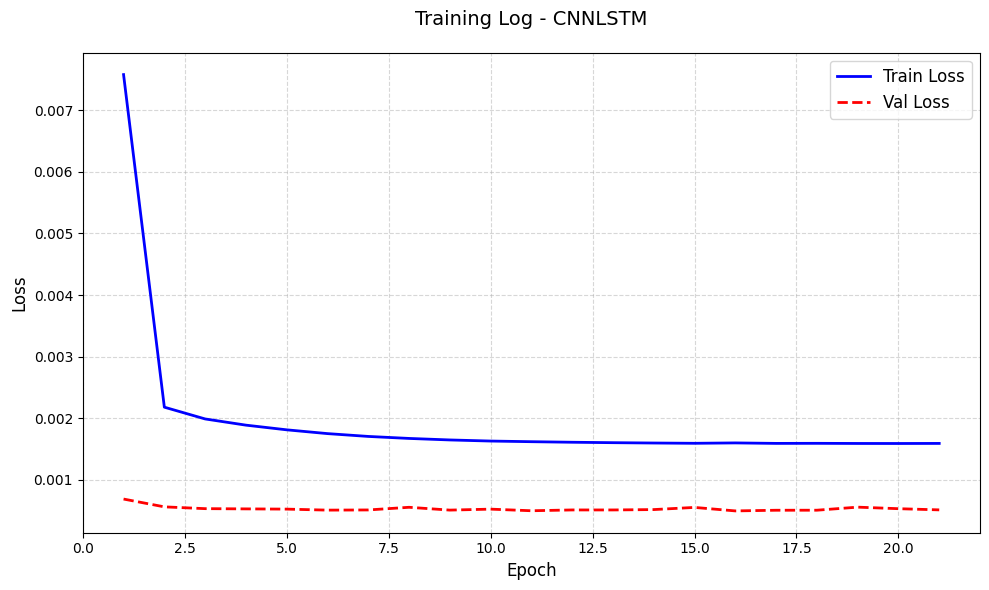

In [17]:
model_name = 'cnnlstm'  # 修改模型名即可
train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=5e-4, weight_decay=1e-4, epochs=50, patience=5, device=device
)

# 可视化训练日志
plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [18]:
model_name = 'cnnlstm'  # 修改模型名即可
errors_6, preds_6, trues_6 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

CNNLSTM Test - Latitude (LAT) - MSE: 0.000495, RMSE: 0.0223, MAE: 0.0136
CNNLSTM Test - Longitude (LON) - MSE: 0.001831, RMSE: 0.0428, MAE: 0.0189
CNNLSTM Total - MSE: 0.001163, RMSE: 0.034101, MAE: 0.016267


LSTMAttention(
  (lstm): LSTM(4, 256, batch_first=True)
  (attn): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=256, out_features=2, bias=True)
  )
)
[LSTMATTN Epoch 01] Train Loss: 0.0047473, Val Loss: 0.0008898
[LSTMATTN Epoch 02] Train Loss: 0.0020520, Val Loss: 0.0007263
[LSTMATTN Epoch 03] Train Loss: 0.0018652, Val Loss: 0.0006511
[LSTMATTN Epoch 04] Train Loss: 0.0018099, Val Loss: 0.0006253
[LSTMATTN Epoch 05] Train Loss: 0.0017759, Val Loss: 0.0006373
[LSTMATTN Epoch 06] Train Loss: 0.0017594, Val Loss: 0.0005922
[LSTMATTN Epoch 07] Train Loss: 0.0017391, Val Loss: 0.0006030
[LSTMATTN Epoch 08] Train Loss: 0.0017239, Val Loss: 0.0006256
[LSTMATTN Epoch 09] Train Loss: 0.0017244, Val Loss: 0.0006320
[LSTMATTN Epoch 10] Train Loss: 0.0017141, Val Loss: 0.0005730
[LSTMATTN Epoch 11] Train 

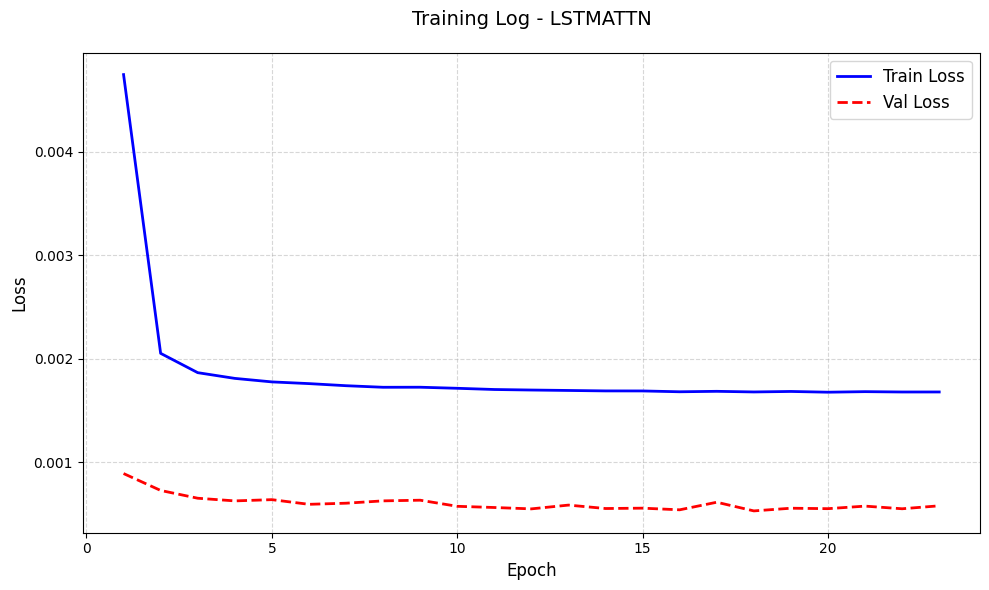

In [19]:
model_name = 'lstmattn'  # 修改模型名即可
train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=1e-3, weight_decay=1e-4, epochs=50, patience=5, device=device
)

# 可视化训练日志
plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [20]:
model_name = 'lstmattn'  # 修改模型名即可
errors_7, preds_7, trues_7 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

LSTMATTN Test - Latitude (LAT) - MSE: 0.000553, RMSE: 0.0235, MAE: 0.0154
LSTMATTN Test - Longitude (LON) - MSE: 0.002064, RMSE: 0.0454, MAE: 0.0224
LSTMATTN Total - MSE: 0.001309, RMSE: 0.036177, MAE: 0.018875


CNNLSTMAttention(
  (conv): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (lstm): LSTM(32, 128, batch_first=True)
  (attn_fc): Linear(in_features=128, out_features=1, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
[CNNLSTMATTN Epoch 01] Train Loss: 0.0073915, Val Loss: 0.0006327
[CNNLSTMATTN Epoch 02] Train Loss: 0.0015708, Val Loss: 0.0005157
[CNNLSTMATTN Epoch 03] Train Loss: 0.0014692, Val Loss: 0.0005071
[CNNLSTMATTN Epoch 04] Train Loss: 0.0014324, Val Loss: 0.0004880
[CNNLSTMATTN Epoch 05] Train Loss: 0.0014184, Val Loss: 0.0004805
[CNNLSTMATTN Epoch 06] Train Loss: 0.0014046, Val Loss: 0.0004721
[CNNLSTMATTN Epoch 07] Train Loss: 0.0013986, Val Loss: 0.0004730
[CNNLSTMATTN Epoch 08] Train Loss: 0.0013910, Val Loss: 0.0005128
[CNNLSTMATTN Epoch 09] Train Loss: 0.0013876, Val Loss: 0.0004636
[CNNLSTMATTN Epoch 10] Train Loss: 0.0013854, Val Loss: 0.0004522
[CNNLSTMATTN Epoch 11] Train Loss: 0.0013780,

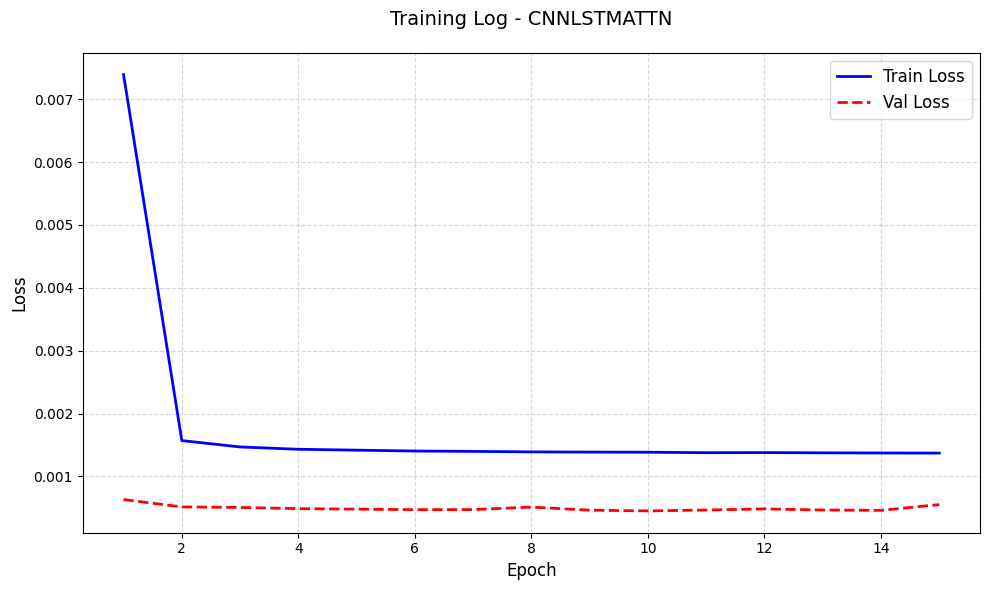

In [21]:
model_name = 'cnnlstmattn'  # 修改模型名即可
train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=5e-4, weight_decay=1e-5, epochs=100, patience=5, device=device
)

# 可视化训练日志
plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [22]:
model_name = 'cnnlstmattn'  # 修改模型名即可
errors_8, preds_8, trues_8 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

CNNLSTMATTN Test - Latitude (LAT) - MSE: 0.000403, RMSE: 0.0201, MAE: 0.0109
CNNLSTMATTN Test - Longitude (LON) - MSE: 0.001550, RMSE: 0.0394, MAE: 0.0143
CNNLSTMATTN Total - MSE: 0.000976, RMSE: 0.031245, MAE: 0.012631


In [11]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

# =========================
# 1. 设置全局参数与函数
# =========================

lat_min, lat_max = 55.5, 58.0
lon_min, lon_max = 10.3, 13.0
feature_cols = ['LAT', 'LON', 'SOG', 'COG']

def create_sliding_windows(data, input_len=6, output_len=1):
    X, y = [], []
    total_len = input_len + output_len
    for i in range(len(data) - total_len + 1):
        X.append(data[i : i + input_len])
        y.append(data[i + input_len : i + total_len])
    return np.array(X), np.array(y)

def denormalize_predictions(preds):
    lat = preds[:, 0] * (lat_max - lat_min) + lat_min
    lon = preds[:, 1] * (lon_max - lon_min) + lon_min
    return np.stack([lat, lon], axis=1)

def prepare_single_mmsi_data(mmsi, df, input_len=6, output_len=1):
    ship_df = df[df["MMSI"] == mmsi].sort_values("BaseDateTime")
    if len(ship_df) < input_len + output_len:
        raise ValueError(f"MMSI {mmsi} 的轨迹太短，无法构建滑动窗口。")

    data = ship_df[feature_cols].values
    X, y = create_sliding_windows(data, input_len, output_len)
    return (
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y[:, 0, :2], dtype=torch.float32),  # 只保留第一步的经纬度
        ship_df.iloc[input_len + output_len - 1:].reset_index(drop=True)
    )

In [14]:
def predict_for_mmsi(model_names, X, model_dir, device='cpu'):
    results = {}
    for model_name in model_names:
        model_path = os.path.join(model_dir, f"s_{model_name}_best.pt")
        model = get_model(model_name).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))
        model.eval()

        preds = []
        with torch.no_grad():
            for i in range(X.shape[0]):
                input_seq = X[i].unsqueeze(0).to(device)  # (1, input_len, 4)
                output = model(input_seq)  # (1, 2)
                preds.append(output.squeeze(0).cpu().numpy())
        preds = np.array(preds)  # (N, 2)
        results[model_name] = preds
    return results

In [13]:
def plot_mmsi_predictions(results_dict, true_positions, title="Trajectory Prediction Comparison"):
    plt.figure(figsize=(12, 6))
    plt.plot(true_positions[:, 1], true_positions[:, 0], label="True", color='black')
    for model_name, preds in results_dict.items():
        plt.plot(preds[:, 1], preds[:, 0], label=f"{model_name} Prediction", linestyle='--')
    plt.xlim(10.3, 13.0)
    plt.ylim(55.5, 58.0)
    plt.xticks(np.arange(10.3, 13.01, 0.5))
    plt.yticks(np.arange(55.5, 58.1, 0.5))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_lon_lat_separately(results_dict, true_positions, title_prefix="Trajectory Component"):
    time_steps = np.arange(len(true_positions))
    # 纬度
    plt.figure(figsize=(12, 4))
    plt.plot(time_steps, true_positions[:, 0], label="True", color='black')
    for model_name, preds in results_dict.items():
        plt.plot(time_steps, preds[:, 0], label=f"{model_name} Prediction", linestyle='--')
    plt.xlabel("Time Step")
    plt.ylabel("Latitude")
    plt.title(f"{title_prefix} - Latitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 经度
    plt.figure(figsize=(12, 4))
    plt.plot(time_steps, true_positions[:, 1], label="True", color='black')
    for model_name, preds in results_dict.items():
        plt.plot(time_steps, preds[:, 1], label=f"{model_name} Prediction", linestyle='--')
    plt.xlabel("Time Step")
    plt.ylabel("Longitude")
    plt.title(f"{title_prefix} - Longitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_31/1865942637.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


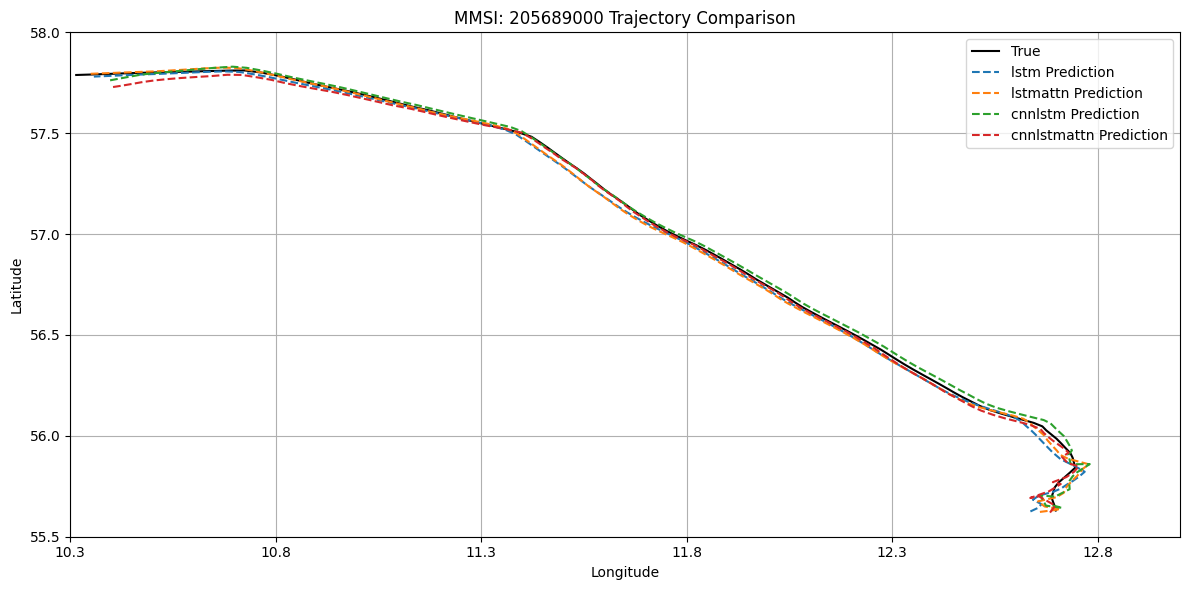

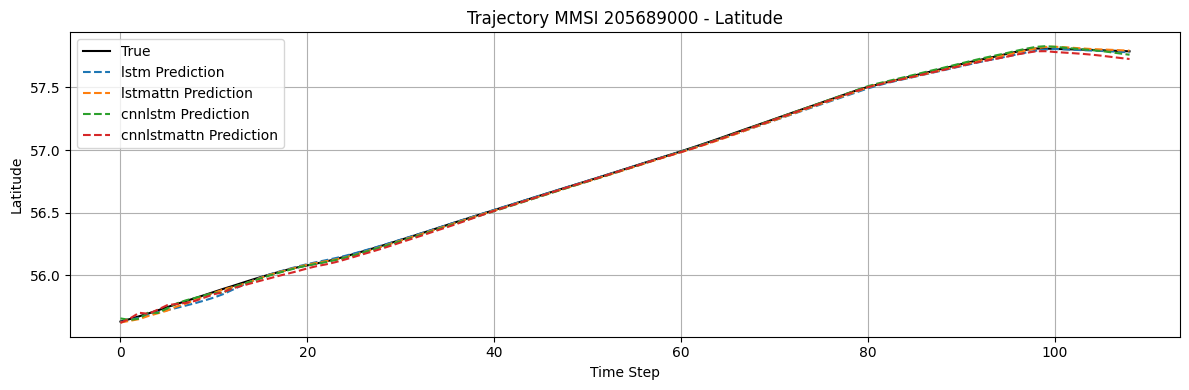

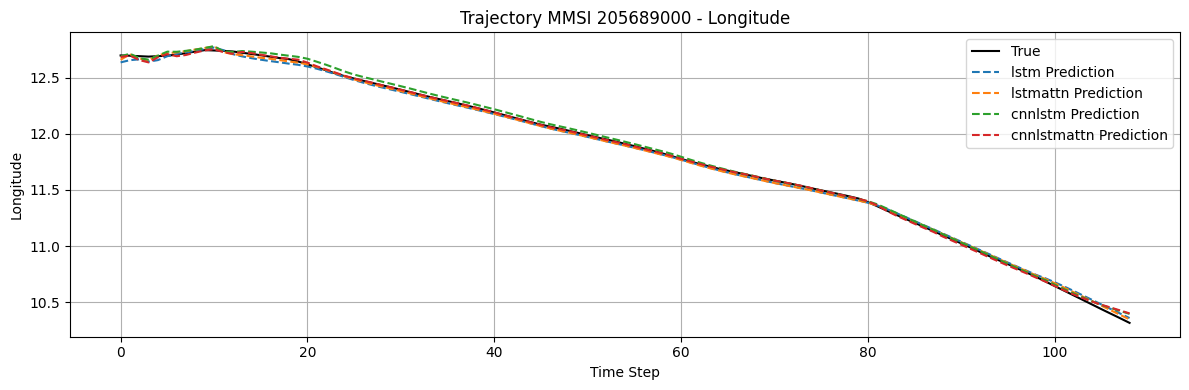

In [26]:
# 加载测试集
test_df = pd.read_csv("/kaggle/input/aisdata/test.csv")

# 自动选择一个 MMSI
target_mmsi = test_df["MMSI"].unique()[1]

# 设置参数
input_len = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = "/kaggle/working/"  # 改成你保存模型的路径
model_names = ['lstm', 'lstmattn', 'cnnlstm', 'cnnlstmattn']  # 你保存的模型名称

# 构造模型输入
X, y, _ = prepare_single_mmsi_data(target_mmsi, test_df, input_len=input_len)

# 模型预测
results = predict_for_mmsi(model_names, X, model_dir, device)

# 反归一化预测结果
true_denorm = denormalize_predictions(y.numpy())
for name in results:
    results[name] = denormalize_predictions(results[name])

# 可视化
plot_mmsi_predictions(results, true_denorm, title=f"MMSI: {target_mmsi} Trajectory Comparison")
plot_lon_lat_separately(results, true_denorm, title_prefix=f"Trajectory MMSI {target_mmsi}")


In [98]:
class GRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h.squeeze(0))

In [99]:
class BiLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = torch.cat([h[0], h[1]], dim=1)
        return self.fc(h)

In [27]:
class Transformer(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 2)  # 预测2维输出（经纬度）

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_linear(x)  # (batch, seq_len, d_model)
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        out = x[:, -1, :]  # 取最后一个时间步的表示
        out = self.fc(out)  # (batch, 2)
        return out

In [60]:
class BiLSTMTransformer(nn.Module):
    def __init__(self, input_dim=4, lstm_hidden=128, lstm_layers=1, d_model=128,
                 nhead=4, trans_layers=2, dropout=0.1):
        super(BiLSTMTransformer, self).__init__()

        # BiLSTM 分支
        self.bilstm = nn.LSTM(
            input_dim, lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.bilstm_dropout = nn.Dropout(dropout)

        # Transformer 分支
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_dropout = nn.Dropout(dropout)

        # 融合层 & 输出层
        fusion_dim = lstm_hidden * 2 + d_model
        self.fc = nn.Linear(fusion_dim, 2)

    def forward(self, x):
        # BiLSTM 分支
        lstm_out, _ = self.bilstm(x)
        lstm_feat = lstm_out[:, -1, :]                # (batch, lstm_hidden*2)
        lstm_feat = self.bilstm_dropout(lstm_feat)

        # Transformer 分支
        x_proj = self.input_proj(x)                   # (batch, seq_len, d_model)
        trans_out = self.transformer(x_proj)
        trans_feat = trans_out[:, -1, :]              # (batch, d_model)
        trans_feat = self.trans_dropout(trans_feat)

        # 融合 + 输出
        fused = torch.cat([lstm_feat, trans_feat], dim=-1)  # (batch, fusion_dim)
        out = self.fc(fused)                                 # (batch, 2)
        return out

In [94]:
class GRUBiLSTMTransformer(nn.Module):
    def __init__(self, input_dim=4, gru_hidden=64, lstm_hidden=128, lstm_layers=1, 
                 d_model=128, nhead=4, trans_layers=2, dropout=0.1):
        super().__init__()
        
        # 1. GRU初步特征提取
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=gru_hidden,
            batch_first=True,
            bidirectional=False
        )
        self.gru_dropout = nn.Dropout(dropout)

        # 2. 并行双分支结构
        # -- BiLSTM分支 --
        self.bilstm = nn.LSTM(
            input_size=gru_hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.bilstm_dropout = nn.Dropout(dropout)

        # -- Transformer分支 --
        self.trans_proj = nn.Linear(gru_hidden, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_dropout = nn.Dropout(dropout)

        # 3. 修正融合层维度计算
        fusion_dim = gru_hidden + lstm_hidden * 2 + d_model  # 关键修正
        self.fc = nn.Linear(fusion_dim, 2)

    def forward(self, x):
        # 输入x形状: (batch, seq_len, input_dim)
        
        # ===== GRU特征提取 =====
        gru_out, _ = self.gru(x)  # (batch, seq_len, gru_hidden)
        gru_features = gru_out[:, -1, :]  # (batch, gru_hidden)
        gru_features = self.gru_dropout(gru_features)

        # ===== 并行双分支 =====
        # -- BiLSTM分支 --
        lstm_out, _ = self.bilstm(gru_out)  # (batch, seq_len, lstm_hidden*2)
        lstm_feat = lstm_out[:, -1, :]  # (batch, lstm_hidden*2)
        lstm_feat = self.bilstm_dropout(lstm_feat)

        # -- Transformer分支 --
        trans_input = self.trans_proj(gru_out)  # (batch, seq_len, d_model)
        trans_out = self.transformer(trans_input)  # (batch, seq_len, d_model)
        trans_feat = trans_out[:, -1, :]  # (batch, d_model)
        trans_feat = self.trans_dropout(trans_feat)

        # ===== 修正特征融合 =====
        fused = torch.cat([gru_features, lstm_feat, trans_feat], dim=1)  # dim=1而非dim=-1
        output = self.fc(fused)  # (batch, 2)
        
        return output

GRUModel(
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
[GRU Epoch 01] Train Loss: 0.0194771, Val Loss: 0.0017438
[GRU Epoch 02] Train Loss: 0.0033057, Val Loss: 0.0012408
[GRU Epoch 03] Train Loss: 0.0024395, Val Loss: 0.0008861
[GRU Epoch 04] Train Loss: 0.0019406, Val Loss: 0.0007055
[GRU Epoch 05] Train Loss: 0.0017026, Val Loss: 0.0006231
[GRU Epoch 06] Train Loss: 0.0016046, Val Loss: 0.0005909
[GRU Epoch 07] Train Loss: 0.0015673, Val Loss: 0.0005728
[GRU Epoch 08] Train Loss: 0.0015522, Val Loss: 0.0005681
[GRU Epoch 09] Train Loss: 0.0015475, Val Loss: 0.0005725
[GRU Epoch 10] Train Loss: 0.0015450, Val Loss: 0.0005613
[GRU Epoch 11] Train Loss: 0.0015431, Val Loss: 0.0005668
[GRU Epoch 12] Train Loss: 0.0015428, Val Loss: 0.0005644
[GRU Epoch 13] Train Loss: 0.0015430, Val Loss: 0.0005705
[GRU Epoch 14] Train Loss: 0.0015428, Val Loss: 0.0005626
[GRU Epoch 15] Train Loss: 0.0015435, Val Loss: 0.0005622
Early stopping at ep

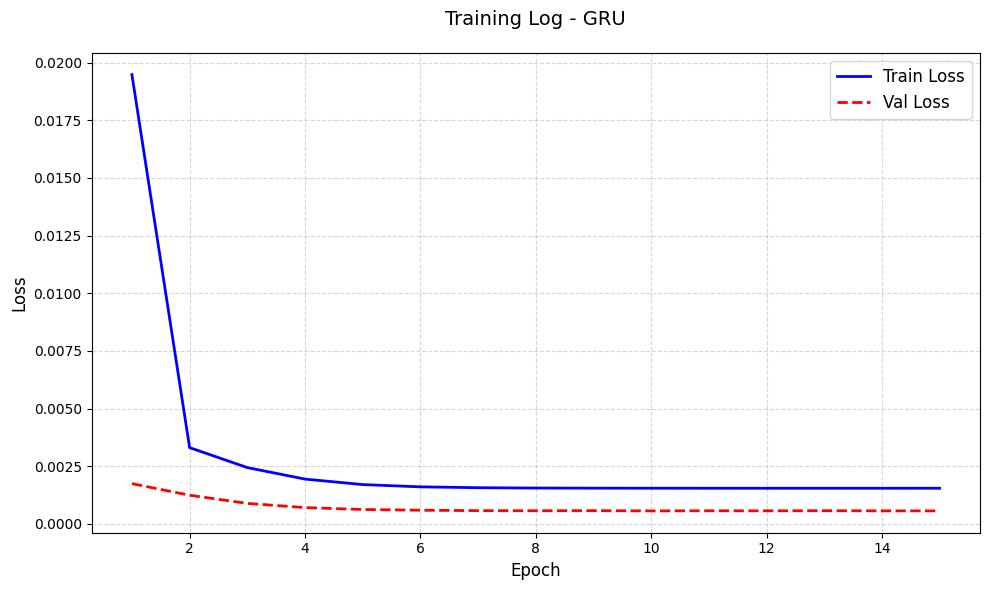

In [21]:
model_name = 'gru'  # 模型名

# 训练 GRU 模型
train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=1e-4, weight_decay=1e-4, epochs=50, patience=5, device=device
)

# 可视化训练日志
plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [22]:
model_name = 'gru'  # 模型名
errors_0, preds_0, trues_0 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

GRU Test - Latitude (LAT) - MSE: 0.001036, RMSE: 0.0322, MAE: 0.0251
GRU Test - Longitude (LON) - MSE: 0.002126, RMSE: 0.0461, MAE: 0.0233
GRU Total - MSE: 0.001581, RMSE: 0.039766, MAE: 0.024219


BiLSTMModel(
  (lstm): LSTM(4, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
[BILSTM Epoch 01] Train Loss: 0.0087956, Val Loss: 0.0006937
[BILSTM Epoch 02] Train Loss: 0.0016315, Val Loss: 0.0005401
[BILSTM Epoch 03] Train Loss: 0.0014574, Val Loss: 0.0004929
[BILSTM Epoch 04] Train Loss: 0.0014117, Val Loss: 0.0004688
[BILSTM Epoch 05] Train Loss: 0.0013908, Val Loss: 0.0005092
[BILSTM Epoch 06] Train Loss: 0.0013829, Val Loss: 0.0004889
[BILSTM Epoch 07] Train Loss: 0.0013743, Val Loss: 0.0004832
[BILSTM Epoch 08] Train Loss: 0.0013645, Val Loss: 0.0004606
[BILSTM Epoch 09] Train Loss: 0.0013560, Val Loss: 0.0004898
[BILSTM Epoch 10] Train Loss: 0.0013428, Val Loss: 0.0005227
[BILSTM Epoch 11] Train Loss: 0.0013295, Val Loss: 0.0005276
[BILSTM Epoch 12] Train Loss: 0.0013270, Val Loss: 0.0004867
[BILSTM Epoch 13] Train Loss: 0.0013237, Val Loss: 0.0004484
[BILSTM Epoch 14] Train Loss: 0.0013071, Val Loss: 0.0004536
[BILSTM Epoc

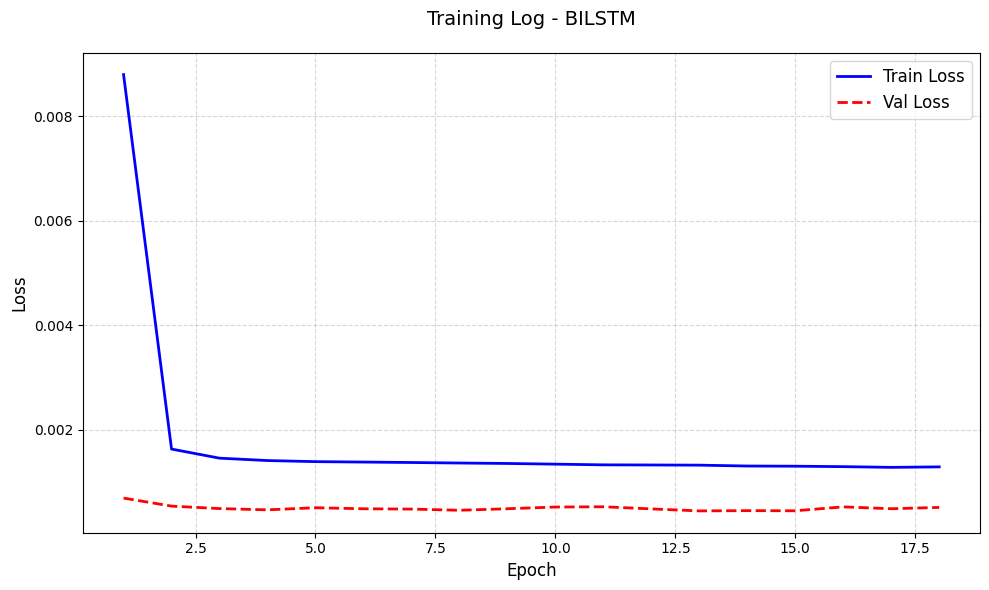

In [37]:
model_name = 'bilstm'

train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=5e-4, weight_decay=0, epochs=50, patience=5, device=device
)

plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)


In [38]:
model_name = 'bilstm'
errors_1, preds_1, trues_1 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

BILSTM Test - Latitude (LAT) - MSE: 0.000426, RMSE: 0.0206, MAE: 0.0114
BILSTM Test - Longitude (LON) - MSE: 0.001646, RMSE: 0.0406, MAE: 0.0182
BILSTM Total - MSE: 0.001036, RMSE: 0.032191, MAE: 0.014770


Transformer(
  (input_linear): Linear(in_features=4, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
[TRANSFORMER Epoch 01] Train Loss: 0.0076122, Val Loss: 0.0005876
[TRANSFORMER Epoch 02] Train Loss: 0.0022880, Val Loss: 0.0005169
[TRANSFORMER E

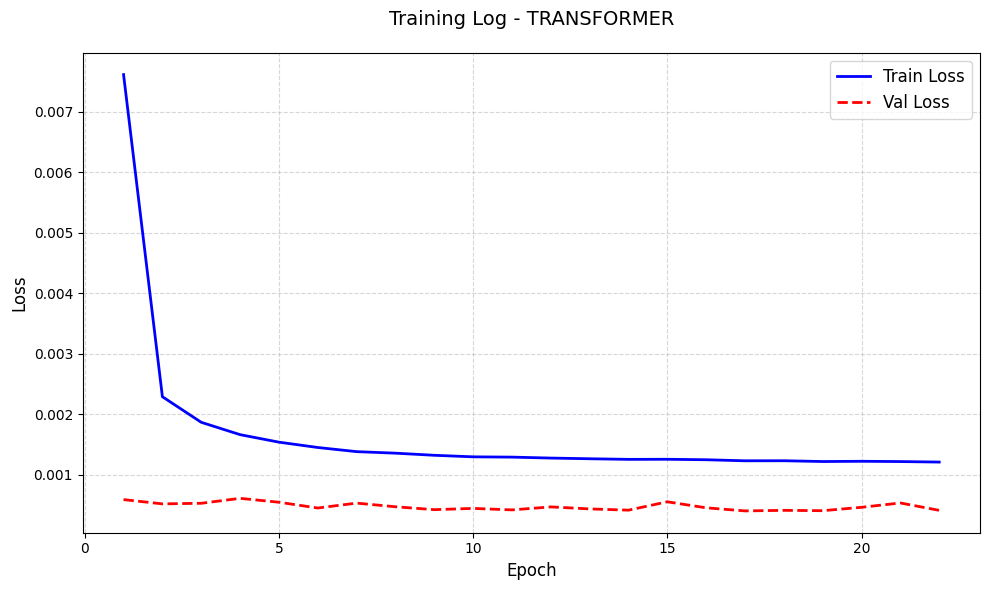

In [47]:
model_name = 'transformer'

train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=1e-4, weight_decay=0, epochs=50, patience=5, device=device
)

plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [48]:
model_name = 'transformer'
errors_2, preds_2, trues_2 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

TRANSFORMER Test - Latitude (LAT) - MSE: 0.000624, RMSE: 0.0250, MAE: 0.0102
TRANSFORMER Test - Longitude (LON) - MSE: 0.001533, RMSE: 0.0391, MAE: 0.0095
TRANSFORMER Total - MSE: 0.001078, RMSE: 0.032833, MAE: 0.009855


BiLSTMTransformer(
  (bilstm): LSTM(4, 128, batch_first=True, bidirectional=True)
  (bilstm_dropout): Dropout(p=0.1, inplace=False)
  (input_proj): Linear(in_features=4, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (trans_dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=384, out_featu

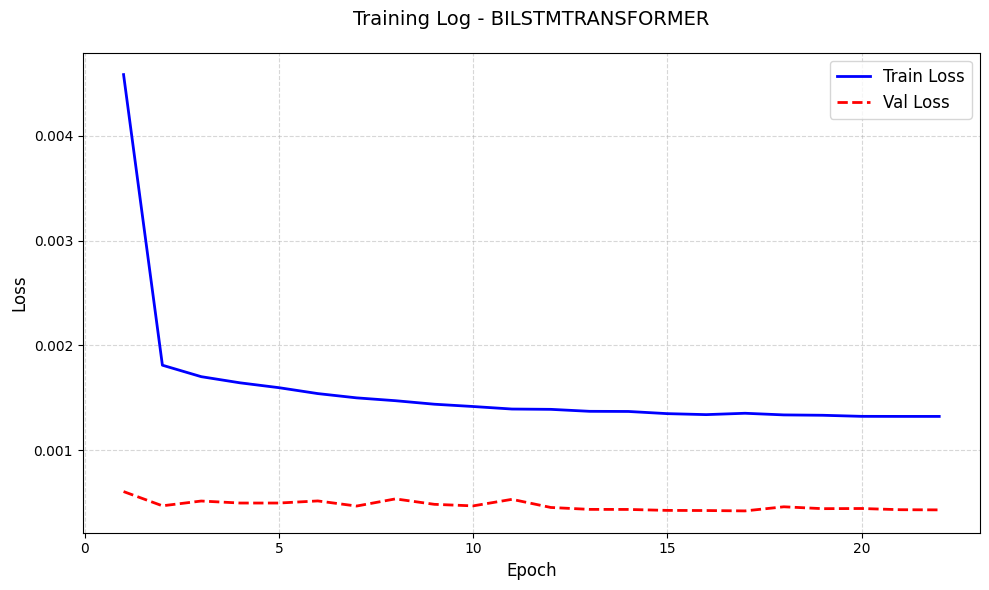

In [61]:
model_name = 'bilstmtransformer'

train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=5e-4, weight_decay=1e-5, epochs=50, patience=5, device=device
)

plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [62]:
model_name = 'bilstmtransformer'
errors_3, preds_3, trues_3 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

BILSTMTRANSFORMER Test - Latitude (LAT) - MSE: 0.000334, RMSE: 0.0183, MAE: 0.0089
BILSTMTRANSFORMER Test - Longitude (LON) - MSE: 0.001383, RMSE: 0.0372, MAE: 0.0119
BILSTMTRANSFORMER Total - MSE: 0.000858, RMSE: 0.029296, MAE: 0.010417


GRUBiLSTMTransformer(
  (gru): GRU(4, 64, batch_first=True)
  (gru_dropout): Dropout(p=0.1, inplace=False)
  (bilstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_dropout): Dropout(p=0.1, inplace=False)
  (trans_proj): Linear(in_features=64, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )


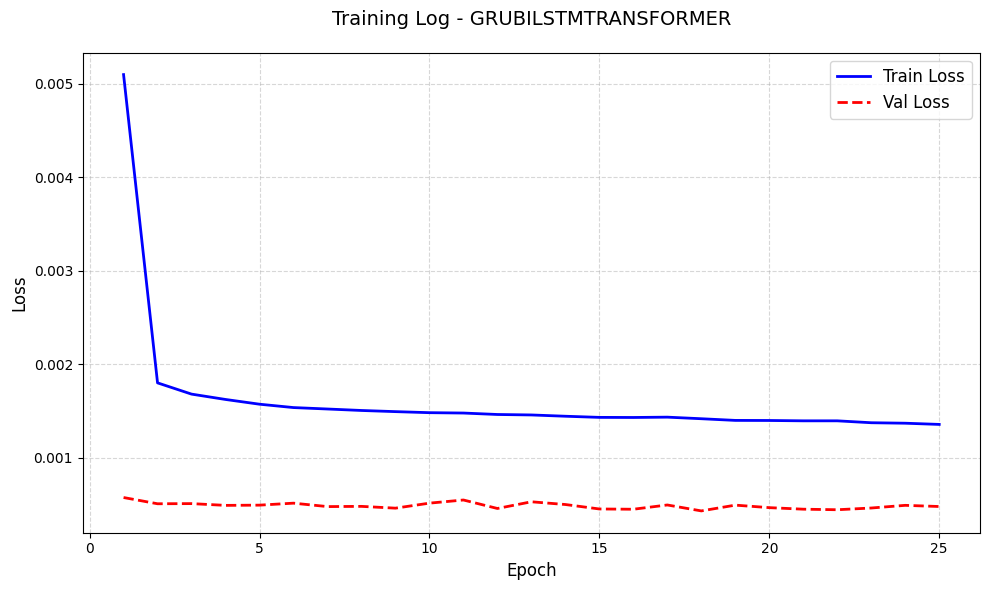

In [95]:
model_name = 'grubilstmtransformer'

train_and_evaluate_model(
    model_name,
    train_loader, val_loader,
    model_dir, log_dir,
    lr=5e-4, weight_decay=1e-5, epochs=50, patience=7, device=device
)

plot_train_log(os.path.join(log_dir, f"s_{model_name}_log.csv"), model_name)

In [96]:
model_name = 'grubilstmtransformer'
errors_4, preds_4, trues_4 = evaluate_model(
    model_name,
    test_loader,
    model_dir,
    device=device
)

GRUBILSTMTRANSFORMER Test - Latitude (LAT) - MSE: 0.000360, RMSE: 0.0190, MAE: 0.0080
GRUBILSTMTRANSFORMER Test - Longitude (LON) - MSE: 0.001322, RMSE: 0.0364, MAE: 0.0103
GRUBILSTMTRANSFORMER Total - MSE: 0.000841, RMSE: 0.028997, MAE: 0.009128


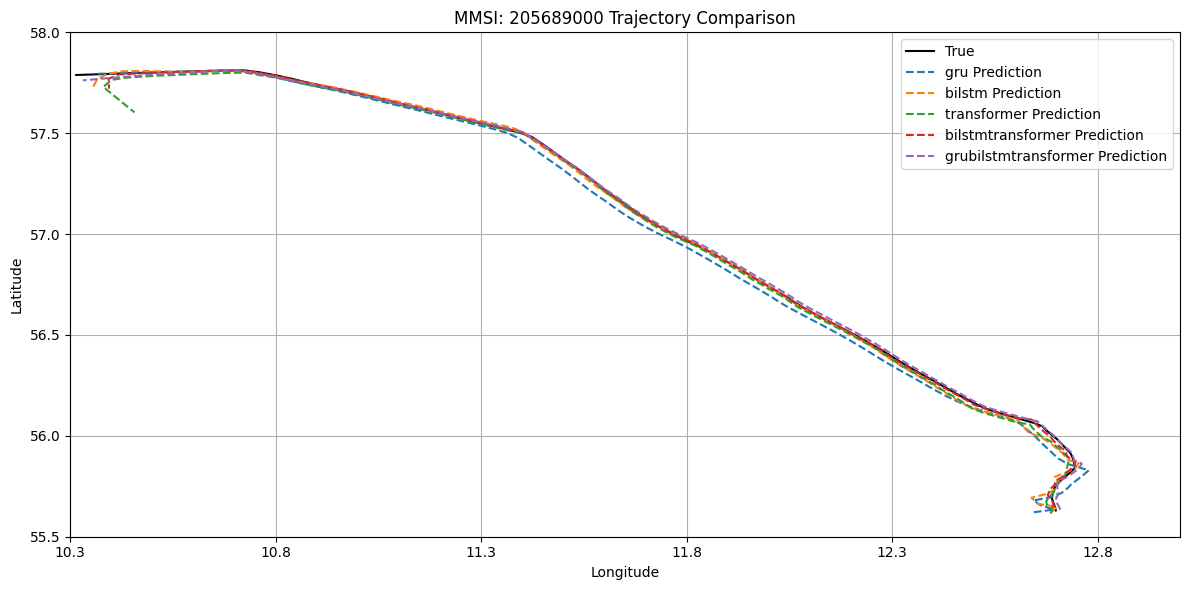

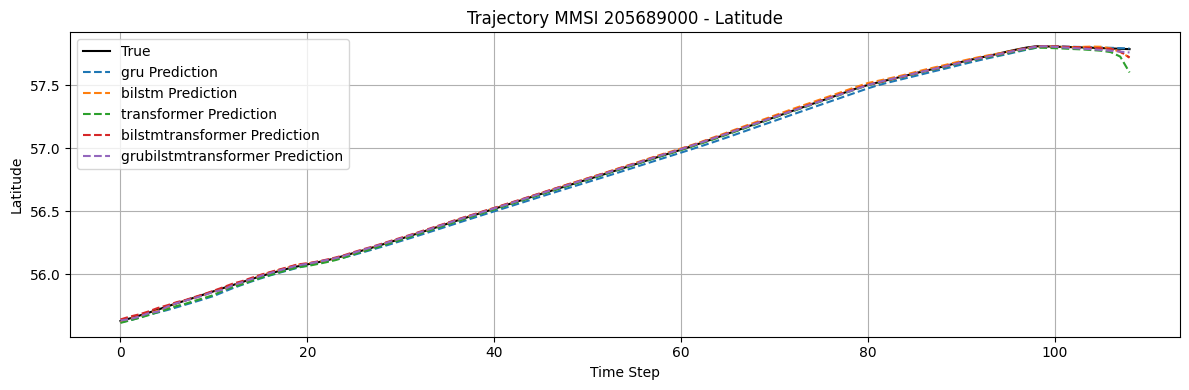

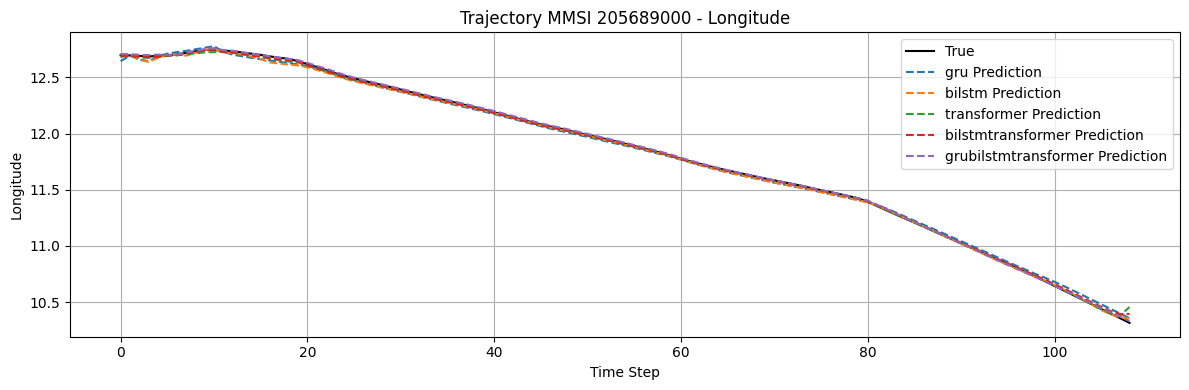

In [100]:
# 加载测试集
test_df = pd.read_csv("/kaggle/input/aisdata/test.csv")

# 自动选择一个 MMSI
target_mmsi = test_df["MMSI"].unique()[1]

# 设置参数
input_len = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_dir = "/kaggle/working/"  # 改成你保存模型的路径
model_names = ['gru', 'bilstm', 'transformer', 'bilstmtransformer','grubilstmtransformer']  # 你保存的模型名称

# 构造模型输入
X, y, _ = prepare_single_mmsi_data(target_mmsi, test_df, input_len=input_len)

# 模型预测
results = predict_for_mmsi(model_names, X, model_dir, device)

# 反归一化预测结果
true_denorm = denormalize_predictions(y.numpy())
for name in results:
    results[name] = denormalize_predictions(results[name])

# 可视化
plot_mmsi_predictions(results, true_denorm, title=f"MMSI: {target_mmsi} Trajectory Comparison")
plot_lon_lat_separately(results, true_denorm, title_prefix=f"Trajectory MMSI {target_mmsi}")
